# Imports

In [1]:
IMPORT_FRESH_ONLY = True # re-import all if False

SELF_TEST = True

In [2]:
# !conda install sentence-transformers -y

In [3]:
# jupyter nbextension enable --py widgetsnbextension
# !conda install ipywidgets widgetsnbextension -y


In [4]:
import logging
import platform
import sys
import os
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
from datetime import datetime
import tensorflow as tf

logger = logging.getLogger('retrain_ipynb')
logger.setLevel(logging.DEBUG)


ch = logging.StreamHandler()
ch.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(levelname)s - %(asctime)s - %(name)s - %(message)s')
ch.setFormatter(formatter)
logger.addHandler(ch)
logger.debug('--=logging started=--')

print(tf.__version__)
CPU = platform.processor()
print (f'Running on CPU:{CPU}')

2023-04-05 15:16:41.514015: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
DEBUG - 2023-04-05 15:16:42,099 - retrain_ipynb - --=logging started=--


2.5.0
Running on CPU:x86_64


In [5]:
nb_dir = os.path.split(os.getcwd())[0]

if nb_dir not in sys.path:
    sys.path.append(nb_dir)

import analyser.hyperparams 
analyser.hyperparams.__file__

Nemoware Analyser v23.3.15
USING WORKDIR: [/root/artem/work]
 set ENV GPN_WORK_DIR to override
datasets_dir: [/root/artem/work/datasets]
reports_dir: [/root/artem/work/reports]


/root/artem/analyser/analyser/hyperparams.py:15: UserWarning: please set GPN_WORK_DIR environment variable
  warnings.warn('please set GPN_WORK_DIR environment variable')


'/root/artem/analyser/analyser/hyperparams.py'

In [6]:
from sentence_transformers import SentenceTransformer
 
sentence_model = SentenceTransformer('distiluse-base-multilingual-cased-v1')
sentence_model.max_seq_length = 512
 

### Prepare workdir

In [7]:
from pathlib import Path

from analyser.hyperparams import work_dir  

# _work_dir_default = Path(analyser.hyperparams.__file__).parent.parent.parent / 'work'
# work_dir = os.environ.get('GPN_WORK_DIR', _work_dir_default)

# if not os.path.isdir(work_dir):
#     os.mkdir(work_dir)

# analyser.hyperparams.work_dir = work_dir
 

print('work_dir=', analyser.hyperparams.work_dir)
assert os.path.isdir(analyser.hyperparams.work_dir)

work_dir= /root/artem/work


### Imports...

In [8]:
%matplotlib inline

import pandas as pd
from pandas import DataFrame

from analyser.finalizer import get_doc_by_id
from analyser.persistence import DbJsonDoc
from integration.db import get_mongodb_connection
from pymongo import ASCENDING, DESCENDING

from analyser.hyperparams import models_path

[documents.py:270 -             __init__() ] loading word cases stats model from: /root/artem/analyser/analyser/vocab/word_cases_stats.pickle
[currencies.py:17 -             _env_var() ] Currency-service : define GPN_CURRENCY_USER environment variable! defaulting to None
[currencies.py:17 -             _env_var() ] Currency-service : define GPN_CURRENCY_PASSWORD environment variable! defaulting to None
[currencies.py:17 -             _env_var() ] Currency-service : define GPN_CURRENCY_URL environment variable! defaulting to None
[tools.py:29 -             __init__() ] model_checkpoint_path: /root/artem/analyser/analyser/vocab


HyperParameters.subsidiary_name_match_min_jaro_similarity 0.9649122807017544


# Init ML Flow logging

In [9]:
import mlflow


ml_flow_url = os.environ.get('MLFLOW_URL', "http://192.168.10.38:5000")
mlflow.set_tracking_uri(ml_flow_url)
print(f'{ml_flow_url=}', 'set MLFLOW_URL env var to re-define')

mlflow.set_experiment("Обучение детектора инсайдерской информации")


active_mlflow_run = mlflow.start_run(nested=False)

ml_flow_url='http://192.168.10.38:5000' set MLFLOW_URL env var to re-define


# Read patterns CSV

In [10]:
# models_path

In [11]:
csv_path = Path(models_path)/'insides_keyphrases.csv'
csv_path.is_file()

True

In [12]:
insides_keyphrases_df = pd.read_csv(csv_path,  sep=';')
insides_keyphrases_df

,Ключевые выражения,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,В предмете договора (в перечне услуг),В правах и обязанностях,В Приложении,NaN,NaN
1,Присвоение Кредитного рейтинга,Предоставить необходимую для проведения Рейтин...,NaN,NaN,NaN
2,Прогноз по Кредитному рейтингу,"Изменение структуры собственности, реорганизац...",NaN,NaN,NaN
3,Поддержание Кредитного рейтинга Заказчика,дополнительную информацию о финансово-хозяйств...,NaN,NaN,NaN
4,NaN,"изменение структуры собственности, реорганизац...",NaN,NaN,NaN
...,...,...,...,...,...
122,Подготовка отчета по результатам мониторинга с...,NaN,NaN,NaN,NaN
123,Подготовка отчета по результатам мониторинга в...,NaN,NaN,NaN,NaN
124,Подготовка отчета по результатам мониторинга ф...,NaN,NaN,NaN,NaN
125,"Сбор аналитических материалов, подготовка спра...",NaN,NaN,NaN,NaN


In [13]:
insides_keyphrases_df = insides_keyphrases_df.iloc[:, 0:2]
insides_keyphrases_df

keyphrases = [ str(r[1]).strip() for i,r in insides_keyphrases_df.iterrows() if pd.notnull(r[1]) ]
keyphrases += [ str(r[0]).strip() for i,r in insides_keyphrases_df.iterrows() if pd.notnull(r[0]) ]


In [14]:
keyphrases[:20]

mlflow.log_param('n_samples_file', len(keyphrases))

133

### Import docs having insideInformation from DB

In [15]:

db = get_mongodb_connection()
documents_collection = db['documents']
sorting = [('user.updateDate', DESCENDING), ('analysis.analyze_timestamp', DESCENDING)]

query = {
  '$and': [
#     {"parse.documentType": "CONTRACT"},      
#     {"state": 15},
    {'$or': [
        {"user.attributes_tree.contract.subject.insideInformation": {"$ne": None}},
        {"user.attributes_tree.contract.insideInformation": {"$ne": None}}
    ]}
  ]
}

res = documents_collection.find(filter=query, 
                                sort=sorting,
                                projection={'_id': True, 'user.updateDate':True}

                               ).limit(5000)

res_inside = list([i for i in res])

_s = f"#### Всего документов с инсайдом  {len(res_inside)}"
display(Markdown(_s))

if SELF_TEST:
    res_inside[:5]

/root/artem/analyser/integration/db.py:14: UserWarning: MongoDB : define GPN_DB_NAME environment variable! defaulting to gpn
  warnings.warn(msg)
/root/artem/analyser/integration/db.py:14: UserWarning: MongoDB : define GPN_DB_PORT environment variable! defaulting to 27017
  warnings.warn(msg)
/root/artem/analyser/integration/db.py:14: UserWarning: MongoDB : define GPN_DB_USER environment variable! defaulting to None
  warnings.warn(msg)
/root/artem/analyser/integration/db.py:14: UserWarning: MongoDB : define GPN_DB_PASSWORD environment variable! defaulting to None
  warnings.warn(msg)
/root/artem/analyser/integration/db.py:14: UserWarning: MongoDB : define GPN_USE_MONGO_TLS environment variable! defaulting to False
  warnings.warn(msg)
/root/artem/analyser/integration/db.py:14: UserWarning: MongoDB : define GPN_DB_TLS_CA environment variable! defaulting to None
  warnings.warn(msg)
/root/artem/analyser/integration/db.py:14: UserWarning: MongoDB : define GPN_DB_TLS_KEY environment varia

DB HOST IS: 192.168.10.36


#### Всего документов с инсайдом  126

### Вынимаем размеченные людьми инсайды из базы

In [16]:
lines=[]
for k, oid in enumerate([i["_id"] for i in res_inside]  ):
    d = get_doc_by_id(oid)
    jd = DbJsonDoc(d)
    tree=jd.user['attributes_tree']
    c = tree.get('contract', {})
    ins = c.get('insideInformation') or  c.get('subject', {}).get('insideInformation', {}) 
    # print('-'*100)
    # print(oid, k, ins)
#     doc=jd.asLegalDoc()
#     quote = doc[ins['span']]
    doc = jd.asLegalDoc()
    s = ins['span']
    quote = doc[s[0]: s[1]].get_normal_text()
    # print(k, quote)
    lines.append( [oid, s[0], s[1], quote, ins['value']]  )
    
insides = DataFrame(lines, columns=['uid', 'from','to', 'text', 'value'])
insides

,uid,from,to,text,value
0,6151b3be8558145da68d8745,137,144,осуществить Авторский надзор за строительством...,Plans
1,6152dfc18558145da68d876d,152,171,"подготовка проектных документов, включая презе...","подготовка проектных документов, включая презе..."
2,6405d9c890beb65b30080ca0,326,363,Продавец продает Покупателю долю в уставном ка...,Продавец продает Покупателю долю в уставном ка...
3,6405d2e990beb65b30080c9e,326,363,Продавец продает Покупателю долю в уставном ка...,Продавец продает Покупателю долю в уставном ка...
4,60f5c5b6d624fbd2b4175db8,127,196,"Заказчик поручает и обязуется оплатить, а Испо...",Deals
...,...,...,...,...,...
121,612344edb8ceba5a6803d249,395,409,1.1. Организатор обязуется оказать Эмитенту ус...,IssuedSecurities
122,610d2b0d7dfce422c4272d33,412,420,"услуги, связанные с выпуском и обращением Обли...",IssuedSecurities
123,60df005595588e4cfb432c2a,142,171,"2.1. Заказчик поручает, а Исполнитель принимае...",Accounting
124,60ec1da0cddbb3c487368c39,129,200,"Заказчик поручает и обязуется оплатить, а Испо...",Deals


In [17]:
mlflow.log_param('n_samples_db', len(insides))

126

## List TOO long samples

In [18]:
print()
for i,r in  insides.iterrows():
    if len(r.text) > 500:
        print(  f'http://gpn-audit.nemosoft.ru/#/pre-audit/edit/{r.uid}', '\n\t' ,r.text)
        print()


http://gpn-audit.nemosoft.ru/#/pre-audit/edit/633ea99b9d08c565cfa1231e 
	 а) копию годового бухгалтерского баланса и отчета о финансовых результатах Клиента, включая копии приложений к указанным документам с отметкой налоговой инспекции, либо с приложением копии квитанций об отправлении отчетности почтой с описью вложений или копии протокола входного контроля при отправке отчетности в электронном виде, подписанные руководителем и заверенные печатью Клиента не позднее, чем через 10 (Десять) дней с последней даты установленных действующим законодательством РФ сроков предоставления бухгалтерской отчетности в налоговые органы;
а также следующую информацию на ежеквартальной основе не позднее 15 мая, 15 августа и 15 ноября каждого года:
б) копии бухгалтерского баланса и отчета о финансовых результатах Клиента по состоянию на 31 марта, 30 июня и 30 сентября каждого года, подписанные руководителем и заверенные печатью Клиента;
в) а также иную информацию дополнительно запрошенную Банком в тече

In [19]:
# !git checkout {models_path}/
# !which python

# !pip install spacy==3.1.2


## Split samples into pieces

In [20]:
from __future__ import unicode_literals, print_function

if True:
    from spacy.lang.ru import Russian # updated

    # raw_text = 'Hello, world. Here are two sentences.'
    nlp = Russian()
    # nlp.add_pipe(nlp.create_pipe('sentencizer')) # updated

    nlp.add_pipe('sentencizer')
    # doc = nlp(raw_text)
    # sentences = [sent  for sent in doc.sents]
    # sentences

    # sentences = [sent.string.strip() for sent in doc.sents]


### Очистка, сортировка, удаление дупликатов

In [21]:

print(models_path)

from analyser.hyperparams import HyperParameters
mean_len = HyperParameters.mean_sentense_pattern_len
print(mean_len)

insides = insides.drop_duplicates(subset=['text'], keep='last')
insides.sort_values(['value']).to_csv(Path(models_path)/'insides.csv', index=True)
print(f'{len(insides)=}')


/root/artem/analyser/analyser/vocab
300
len(insides)=78


### Удаление слишком коротких

In [22]:
from analyser.legal_docs import tokenize_doc_into_sentences_map

strings = [ r.text for i,r in  insides.iterrows() ]


strings_ =[]
nonsense = []
for j, s in enumerate(strings):
    doc = nlp(s)
#     m = tokenize_doc_into_sentences_map(s, max_len_chars = HyperParameters.mean_sentense_pattern_len)
#     print('='*100)
#     print(m.tokens)
    for i in doc.sents:     
        sent = str(i).strip()
        if len(sent) > 400:    
            print('*'*100)
            print(f'{len(sent)}\t {insides.iloc[j].uid}\t {sent}')
        if len(sent) > 12:            
            strings_.append(sent)
        else:
            nonsense.append(sent)
#             print ('- excl:', sent)
        
strings = strings_



strings+=[ 'Заказчик передает Исполнителю данные аккаунтов (логин и пароль) в социальных сетях',
         'если особенностями процесса оказания услуг обусловлена необходимость доступа персонала Исполнителя к \
         электронным информационным системам, программам и базам данных, Заказчик гарантирует предоставление Исполнителю \
         такого доступа в соответствии с локальными нормативными актами Заказчика и при прохождении процедур инструктажа, \
         установленных Заказчиком, не противоречащих действующему законодательству, в течение первых двух дней выездной аудиторской проверки',
         'Заказчик обязуется предоставить Исполнителю окончательный вариант годового отчета и/или отчета эмитента (или иной информации), включая совокупность документов, \
         совместно составляющих годовой отчет, чтобы Исполнитель мог завершить процедуры, необходимые в соответствии с требованиями MCA']


nonsense.append('Губкина, дом 1')
nonsense.append('без всякого смысла')
nonsense.append(' ')
nonsense.append('non abra kadabra plus')
nonsense.append('gazprom-neft.')

nonsense += ['за заданный исторический период.',
             'Губкина, дом 1 (далее - «Объект»)', 
             'Строительство производства катализаторов 2 этап», находящихся по адресу: 644040, г.',
             'поставку Покупателю экземпляров программного обеспечения jFrog Artifactory Pro X Edition',
             'Строительство производства катализаторов'
            ]



strings+=keyphrases

****************************************************************************************************
1695	 633ea99b9d08c565cfa1231e	 а) копию годового бухгалтерского баланса и отчета о финансовых результатах Клиента, включая копии приложений к указанным документам с отметкой налоговой инспекции, либо с приложением копии квитанций об отправлении отчетности почтой с описью вложений или копии протокола входного контроля при отправке отчетности в электронном виде, подписанные руководителем и заверенные печатью Клиента не позднее, чем через 10 (Десять) дней с последней даты установленных действующим законодательством РФ сроков предоставления бухгалтерской отчетности в налоговые органы;
а также следующую информацию на ежеквартальной основе не позднее 15 мая, 15 августа и 15 ноября каждого года:
б) копии бухгалтерского баланса и отчета о финансовых результатах Клиента по состоянию на 31 марта, 30 июня и 30 сентября каждого года, подписанные руководителем и заверенные печатью Клиента;
в) а так

In [23]:
print(nonsense)

['Омск, пр.', '1.1.1.', '', '', 'д.)', 'д.)', '7.2.', '', '', '', 'д.)', '5.2.2.', '3.2.3.', '1.5.', '1.1.', '1.1.', '2.1.', 'Омск, пр.', 'Омск, пр.', 'Губкина, дом 1', 'без всякого смысла', ' ', 'non abra kadabra plus', 'gazprom-neft.', 'за заданный исторический период.', 'Губкина, дом 1 (далее - «Объект»)', 'Строительство производства катализаторов 2 этап», находящихся по адресу: 644040, г.', 'поставку Покупателю экземпляров программного обеспечения jFrog Artifactory Pro X Edition', 'Строительство производства катализаторов']


## Vectorisation des modèles

In [24]:
 

embedd_strings = sentence_model.encode



### Trouver le centre d'absurdité (фр. поиск центра абсурда)

In [25]:
%%time
nonsense_embeddings = embedd_strings(nonsense)
center_of_nonsense = nonsense_embeddings.mean(axis=0)
center_of_nonsense.shape

CPU times: user 908 ms, sys: 467 ms, total: 1.38 s
Wall time: 1.37 s


(512,)

In [26]:
%%time
# embeddings = embedder.embedd_strings(strings) #WARNing! these are context-scpecific

embeddings_l = []
for s in strings:
    e = embedd_strings([s])
    embeddings_l.append(e[0])
    

CPU times: user 912 ms, sys: 4.78 ms, total: 917 ms
Wall time: 916 ms


(233, 512) 0.17851007 -0.20710738
CPU times: user 12.3 ms, sys: 64 µs, total: 12.3 ms
Wall time: 11.4 ms


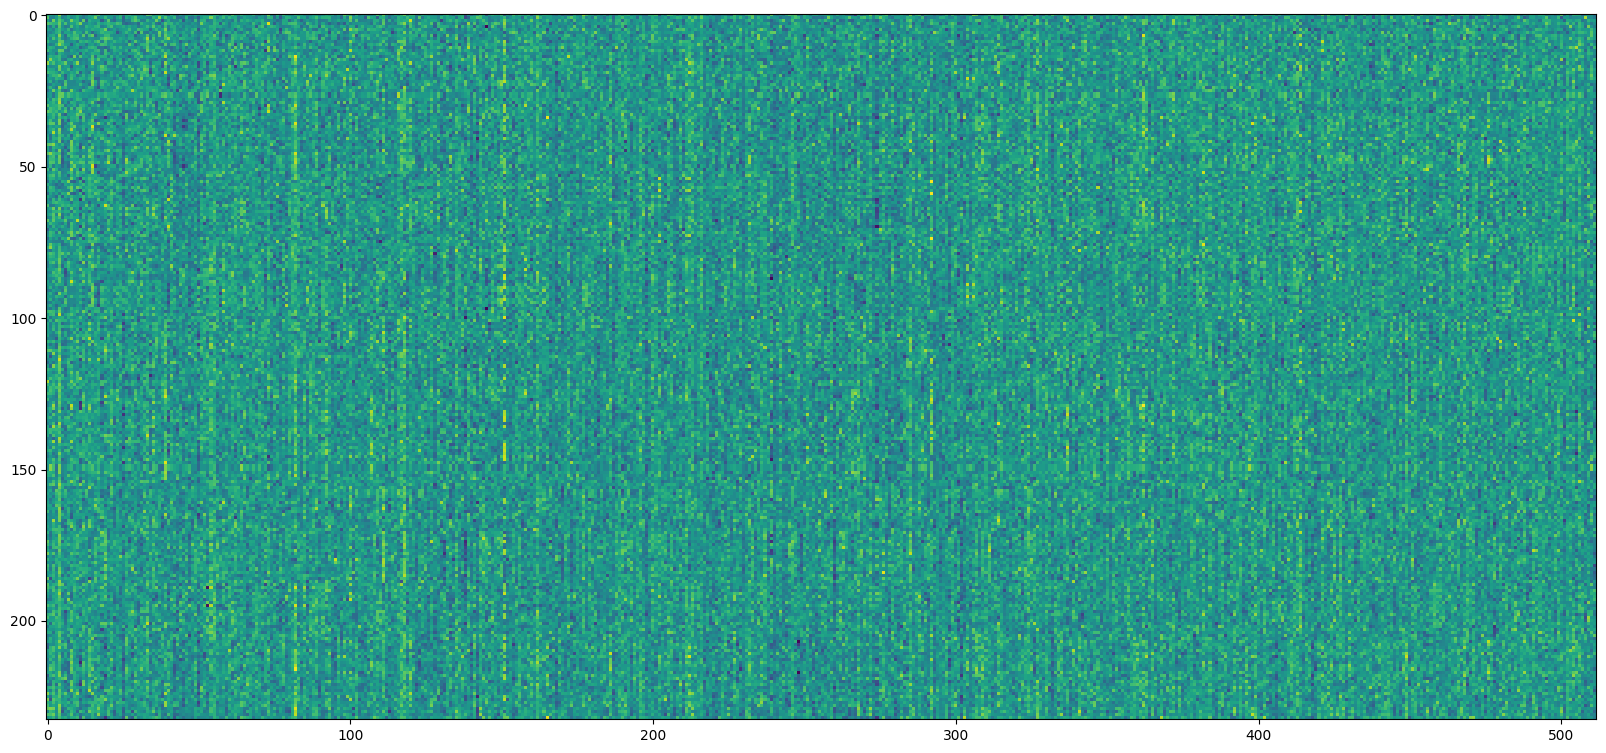

In [27]:
%%time
import numpy as np
embeddings = np.array(embeddings_l)
print(embeddings.shape, embeddings.max(), embeddings.min())

plt.figure(figsize=(20,10))
plt.imshow(embeddings)


## pair-wise distances of Embeddings, removing duplicates

(233, 233)
distance_matrix mean 0.88897705
distance_matrix max 1.2067984
distance_matrix std 0.13949656


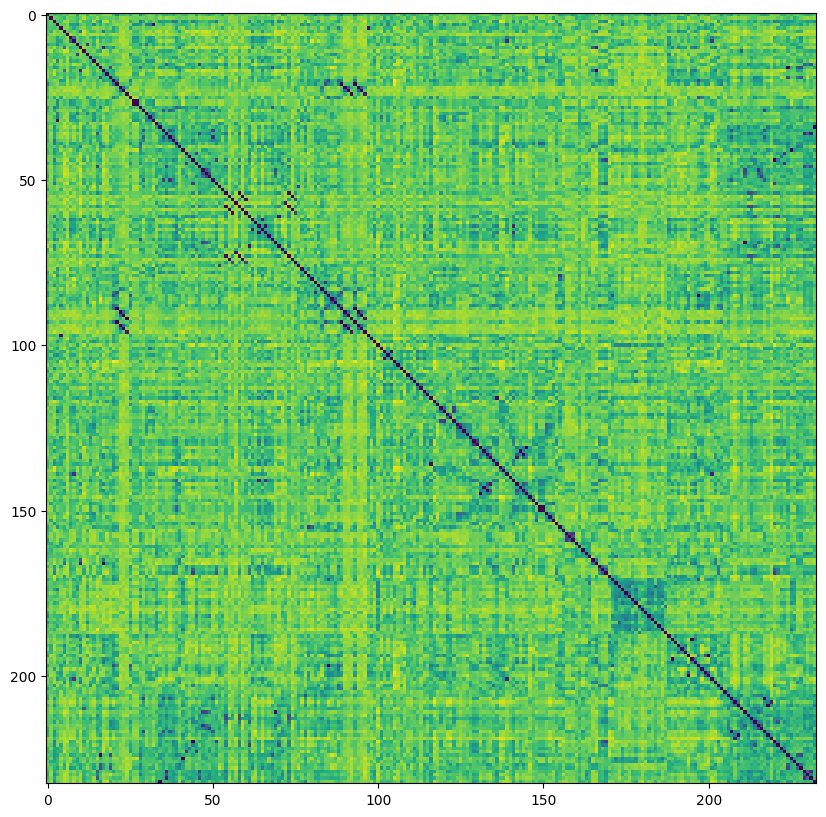

In [28]:
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import normalize

distance_matrix = pairwise_distances(embeddings, embeddings, metric='cosine', n_jobs=1)
print(distance_matrix.shape)
# distance_matrix

plt.figure(figsize=(10,10))
plt.imshow(distance_matrix)
print('distance_matrix mean', distance_matrix.mean())
print('distance_matrix max', distance_matrix.max())
print('distance_matrix std', distance_matrix.std())

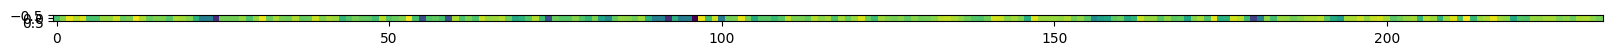

In [29]:
nonsense_distance_matrix = pairwise_distances(embeddings, [center_of_nonsense], metric='cosine', n_jobs=1)
plt.figure(figsize=(20,20))
plt.imshow(nonsense_distance_matrix.T)

In [30]:
# len(X)

In [31]:
_excluded = set()
_kept = set()

_b=0.7
nonsense_thr = nonsense_distance_matrix.mean() * _b + nonsense_distance_matrix.min() * (1-_b)
print('nonsense_thr', nonsense_thr)

display(Markdown(f'### Бессмысленные паттерны или почти:: \
        distance < {nonsense_thr:.2} (min={nonsense_distance_matrix.min():.2}; mean={nonsense_distance_matrix.mean():.2})'))
for i, nd in enumerate(nonsense_distance_matrix):
    d = nd[0]
    if d < nonsense_thr:
        ## trop proche de l'absurde
        print('---')
        _excluded.add(i)
        print(i, d, '\t',strings[i])

nonsense_thr 0.9479039251804351


### Бессмысленные паттерны или почти::         distance < 0.95 (min=0.74; mean=1.0)

---
22 0.90335363 	 Строительство производства катализаторов 1 этап» и «Объекты основного производства и ОЗХ.
---
23 0.9093815 	 Строительство производства катализаторов 2 этап», находящихся по адресу: 644040, г.
---
24 0.7862995 	 Губкина, дом 1 (далее - «Объект
---
55 0.8319648 	 за заданный исторический период.
---
59 0.8319648 	 за заданный исторический период.
---
74 0.8319648 	 за заданный исторический период.
---
83 0.9231932 	 Проектной и/или Рабочей документации и выполнению инженерных изысканий на АО "Газпромнефть-ОНПЗ" Объекта: " Строительство производства катализаторов" в соответствии с Заданием на проектирование (Приложение № 1 к Договору) в сроки, определенные Календарным планом (Приложение № 3 к Договору)
---
90 0.90335363 	 Строительство производства катализаторов 1 этап» и «Объекты основного производства и ОЗХ.
---
91 0.9093815 	 Строительство производства катализаторов 2 этап», находящихся по адресу: 644040, г.
---
92 0.7839346 	 Губкина, дом 1 (далее - «Объект»)
---


In [32]:
np.percentile(distance_matrix, 0.5)

1.1920928955078125e-07

In [33]:
simlarity_threshold = np.percentile(distance_matrix, 0.5)
display(Markdown(f'### Одинаковые: расстояние < {simlarity_threshold:.2}'))
for i in range(distance_matrix.shape[0]):
    for j in range(i+1, distance_matrix.shape[0]):
        
        d = distance_matrix[i,j]
        
        if d < simlarity_threshold:
            print(i,'vs', j, ', cosine distance =', d)
            _kept.add(i)
            _excluded.add(j)
            

            print(i, strings[i])
            print('='*10)
            print(j, strings[j])
            print('-'*100)
       
# _excluded
display(Markdown(f'#### {len(_excluded)} одинаковых пар'))
print(_kept - _excluded)
print(_excluded)

### Одинаковые: расстояние < 1.2e-07

17 vs 166 , cosine distance = 0.0
17 По настоящему Соглашению Кредитор обязуется открыть Заемщику Кредитную линию в размере и на условиях, указанных в настоящем Соглашении, а Заемщик обязуется возвратить Кредит, полученный по Кредитной линии, уплатить проценты и выполнить иные Обязательства, предусмотренные настоящим Соглашением
166 По настоящему Соглашению Кредитор обязуется открыть Заемщику Кредитную линию в размере и на условиях, указанных в настоящем Соглашении, а Заемщик обязуется возвратить Кредит, полученный по Кредитной линии, уплатить проценты и выполнить иные Обязательства, предусмотренные настоящим Соглашением
----------------------------------------------------------------------------------------------------
21 vs 89 , cosine distance = 0.0
21 Заказчик поручает и обязуется оплатить, а Исполнитель обязуется: осуществить Авторский надзор за строительством объектов Заказчика (далее - «Услуги»): «Лабораторно-аналитический комплекс.
89 Заказчик поручает и обязуется оплатить, а И

#### 27 одинаковых пар

{194, 34, 132, 44, 17, 21, 54, 85, 189}
{143, 22, 23, 24, 156, 166, 180, 181, 55, 58, 59, 195, 197, 200, 74, 83, 89, 90, 91, 92, 93, 94, 95, 96, 220, 100, 232}


In [34]:
# for i in range(distance_matrix.shape[0]):
#     if len(strings[i]) < 15:
#         print(strings[i])
#     if len(strings[i]) > 400 :
#         print('-'*100)
#         print(strings[i])
        
#         _excluded.add(i)

In [35]:
import numpy as np
embeddings_filtered = np.delete(embeddings, list(_excluded), axis=0)
strings_filtered = np.delete(strings, list(_excluded), axis=0)
print(embeddings_filtered.shape)

display(Markdown(f'### {embeddings_filtered.shape[0]} -- Количество паттернов после удаления одинаковых'))


del embeddings
del strings

strings = strings_filtered
embeddings = embeddings_filtered

mlflow.log_param('n_samples', embeddings_filtered.shape[0])

(206, 512)


### 206 -- Количество паттернов после удаления одинаковых

206

In [36]:
# import pandas as pd
 
# for
# df_describe = pd.DataFrame(distance_matrix)
# print("distance_matrix mean=", distance_matrix.mean())
# print("distance_matrix std=", distance_matrix.std())
# df_describe.describe()


#collect all elements except diagonal zeros
#XXX: mighe be done with smatr sliceing, but im too lazy


def estimate_distance_threshold(patterns_embeddings):
    distance_matrix = pairwise_distances(patterns_embeddings, patterns_embeddings, metric='cosine', n_jobs=1)
    
    dshape = distance_matrix.shape
    distance_matrix_meaningful=[]
    for i in range(dshape[0]):
        for j in range(i):
            distance_matrix_meaningful.append(distance_matrix[i][j])
    distance_matrix_meaningful=np.array(distance_matrix_meaningful)
    len(distance_matrix_meaningful)            

    print("distance_matrix mean=", distance_matrix_meaningful.mean())
    print("distance_matrix max=", distance_matrix_meaningful.max())
    print("distance_matrix std=", distance_matrix_meaningful.std())

    #mean distance plus/minus tandart deviation .. estimating the max distance from clusters...
    threshold = distance_matrix_meaningful.mean() - distance_matrix_meaningful.std() 
    return threshold
    
estimate_distance_threshold(embeddings_filtered)

distance_matrix mean= 0.8818321
distance_matrix max= 1.2067984
distance_matrix std= 0.12491495


0.7569172

## Clustering, t-SNE  3D

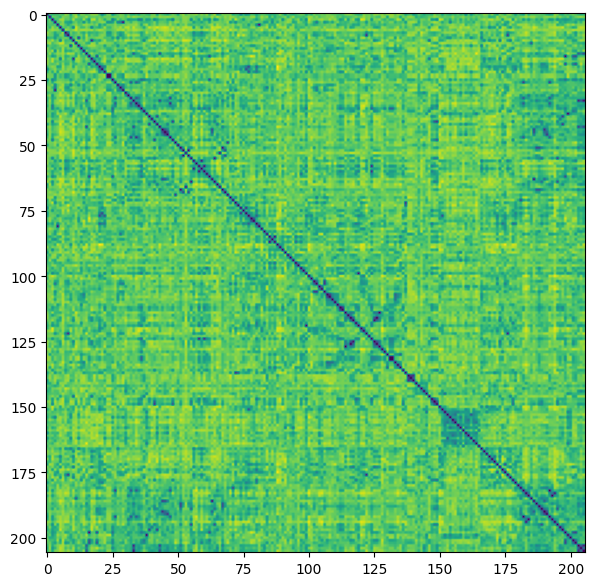

In [37]:

distance_matrix = pairwise_distances(embeddings_filtered, embeddings_filtered, metric='cosine', n_jobs=1)

            
plt.figure(figsize=(7,7))
plt.imshow(distance_matrix)

In [38]:
# print(insides.value.unique())????
n_clusters = embeddings_filtered.shape[0] // 10 #len(insides.value.unique())
print('n_clusters', n_clusters)

n_clusters 20


## Clustering, t-SNE  2D

In [39]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=6000, metric="precomputed")
tsne_results = tsne.fit_transform(distance_matrix)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 206 samples in 0.000s...
[t-SNE] Computed neighbors for 206 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 206 / 206
[t-SNE] Mean sigma: 0.321533
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.475594


/root/artem/env/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


[t-SNE] KL divergence after 1150 iterations: 0.562926


<AxesSubplot:xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

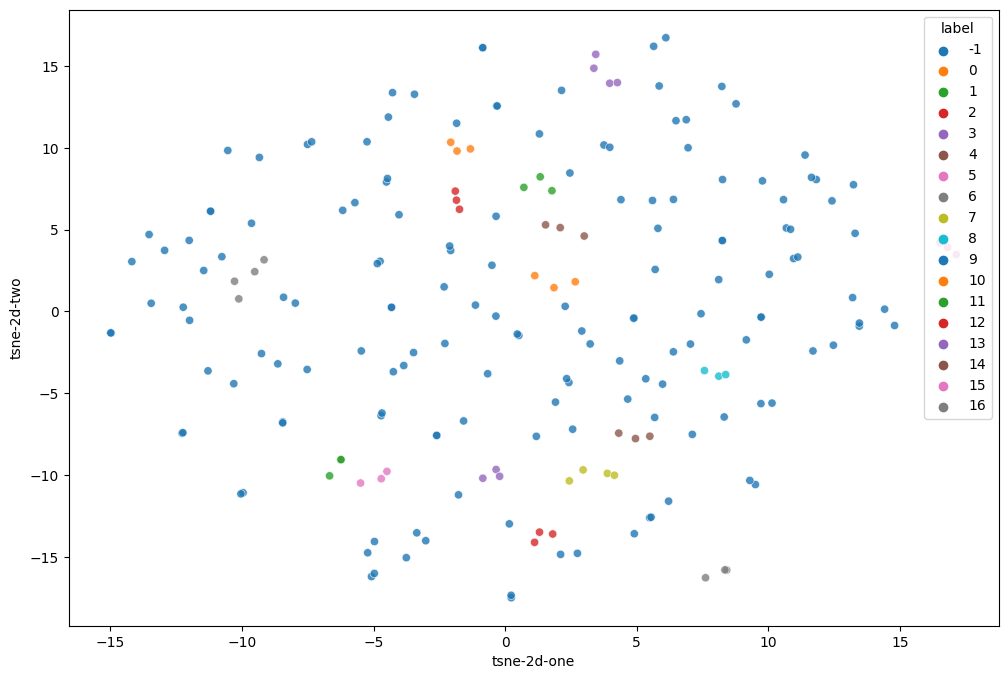

In [40]:
# from sklearn.cluster import SpectralClustering

# kmeans = KMeans(n_clusters = n_clusters, random_state=0).fit(np.array(tsne_results))
kmeans = DBSCAN(eps=1.1, min_samples=3 ).fit(tsne_results)
# kmeans = SpectralClustering(n_clusters=n_clusters, assign_labels='discretize', random_state=0).fit(tsne_results)

df_subset={}
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]
df_subset['label'] = kmeans.labels_


fig=plt.figure(figsize=(12,8) )
# ax = fig.add_subplot(111, projection = '3d')


# ax.scatter(df_subset['tsne-2d-one'], df_subset['tsne-2d-two'], df_subset['tsne-2d-3'])

# plt.show()

sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="label", palette="tab10",
    data=df_subset,
    alpha=0.8
)



In [41]:
kmeans.__dict__

{'eps': 1.1,
 'min_samples': 3,
 'metric': 'euclidean',
 'metric_params': None,
 'algorithm': 'auto',
 'leaf_size': 30,
 'p': None,
 'n_jobs': None,
 'n_features_in_': 2,
 'core_sample_indices_': array([  8,  26,  33,  39,  41,  42,  47,  52,  54,  55,  58,  60,  68,
         76,  77,  82, 106, 107, 120, 121, 122, 124, 133, 137, 138, 139,
        140, 155, 156, 176, 182, 192, 195, 197, 203, 205]),
 'labels_': array([-1, -1, -1, -1, -1, -1, -1, -1,  0, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, 10,  9, -1, -1, -1, -1,  1, -1, -1, -1, -1, -1,  5,  2,
         5, -1, -1, -1, -1,  3, -1,  4,  3, -1, -1, -1, -1,  5,  4, -1, -1,
        -1,  6, -1,  6,  7, -1, -1,  8, -1,  8, -1, -1, -1,  7, -1, -1, -1,
         6, -1, -1, -1, 14, 14,  9, -1,  9, 10, -1, -1, -1, -1, 11, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        12, 12, -1, -1, 12, 13, 13, 13, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, 11, 11,  0, -1,  8, -1, -1, -1, -1, -1, -1, 

In [42]:
# set(kmeans.labels_)

In [43]:
# !conda list

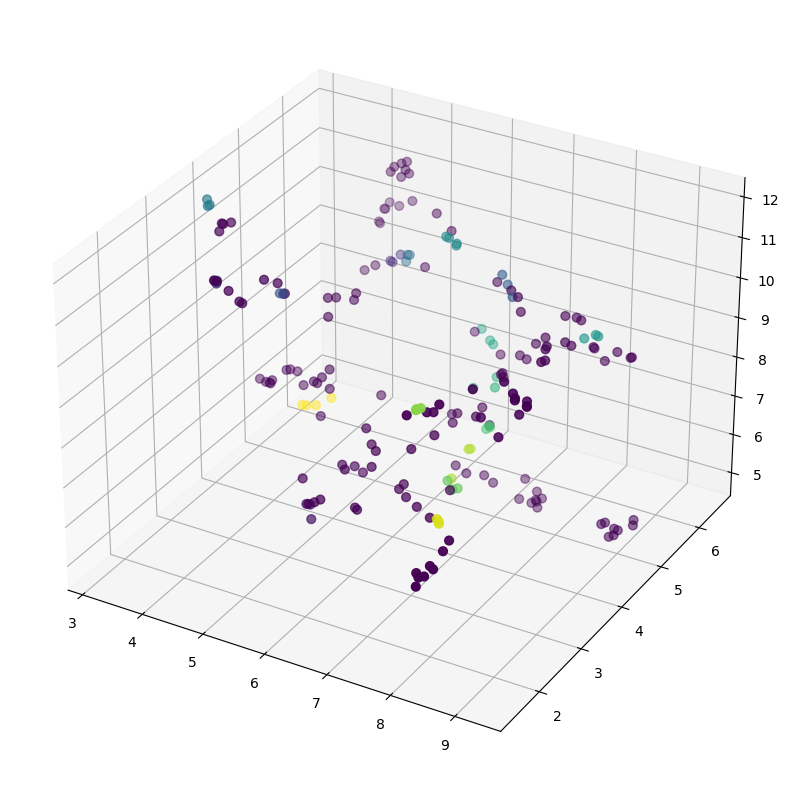

In [44]:
import umap
umap_embeddings = (umap.UMAP(n_neighbors=6, 
                                n_components=3, 
                                metric='cosine', 
                                random_state=42)
                            .fit_transform(embeddings_filtered))


fig=plt.figure(figsize=(10,10) )
ax = fig.add_subplot(111, projection = '3d')

ax.scatter(umap_embeddings[:,0], umap_embeddings[:,1], umap_embeddings[:,2], s=40, c=df_subset['label'] )
 
plt.show()

/root/artem/env/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 206 samples in 0.000s...
[t-SNE] Computed neighbors for 206 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 206 / 206
[t-SNE] Mean sigma: 0.313323
[t-SNE] KL divergence after 250 iterations with early exaggeration: 139.094345
[t-SNE] KL divergence after 5000 iterations: 2.038987
clusters3d.labels_ {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, -1}


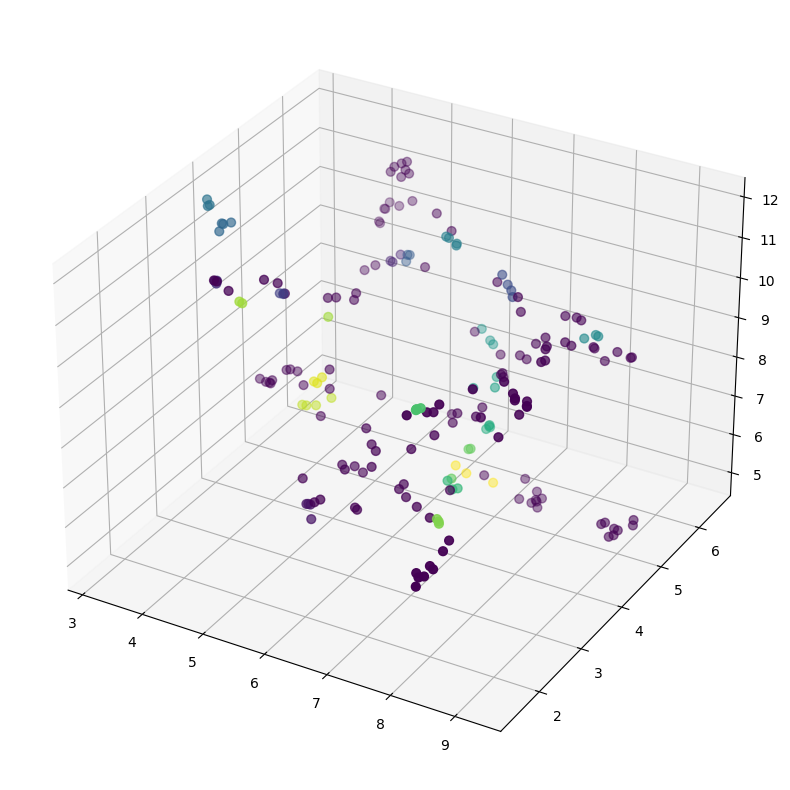

In [47]:
from matplotlib.colors import ListedColormap
 
cmap = ListedColormap(sns.color_palette("husl", 256).as_hex())


# from sklearn.cluster import Birch

from sklearn.manifold import TSNE
tsne = TSNE(n_components=3, verbose=1, perplexity=30, n_iter=5000, metric="precomputed")
tsne_results3 = tsne.fit_transform(distance_matrix)




tsne_results3 = umap_embeddings #XXXXXX



# clusters3d = KMeans(n_clusters = n_clusters, random_state=0).fit(np.array(tsne_results))
clusters3d = DBSCAN(eps=1.2, min_samples=3).fit(tsne_results)

print('clusters3d.labels_',set(clusters3d.labels_))
df_subset={}
df_subset['tsne-2d-one'] = tsne_results3[:,0]
df_subset['tsne-2d-two'] = tsne_results3[:,1]
df_subset['tsne-2d-3'] = tsne_results3[:,2]
df_subset['label'] = clusters3d.labels_


fig = plt.figure(figsize=(10,10) )
ax = fig.add_subplot(111, projection = '3d')

ax.scatter(df_subset['tsne-2d-one'], df_subset['tsne-2d-two'], df_subset['tsne-2d-3'], s=40, c=df_subset['label'] )
 
plt.show()

mlflow.log_figure(fig, 'clusters_of_samples_(TSNE_DBSCAN).png')

In [48]:
insides.to_csv('insides.csv', index=True)

In [49]:
# print(len(pca_result))

In [50]:
from colab_support.renderer import HtmlRenderer
import matplotlib as matplotlib
from IPython.core.display import display, HTML

class DemoRenderer(HtmlRenderer):
  def render_color_text(self, tokens, weights, colormap='coolwarm', print_debug=False, _range=None, separator=' '):
    html = self.to_color_text(tokens, weights, colormap, print_debug, _range, separator=separator)
    display(HTML(html))

  def to_color_text(self, tokens, weights, colormap='coolwarm', print_debug=False, _range=None, separator=' '):
    return super()._to_color_text(tokens, weights, matplotlib, colormap=colormap, _range=_range, separator=separator)

renderer_ = DemoRenderer()

# if SELF_TEST:
#     renderer_.render_color_text(["слово 1", "слово 2"], np.array( [1, 0]), _range=(0,1))

/tmp/ipykernel_2261070/2930756925.py:3: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


## Finding cluster centers (in embedding space)

In [51]:
lens = [ len (s) for s in strings]
print(lens)

__mean_len = int(np.mean(lens) * 1.75)
print(__mean_len)

[65, 202, 83, 164, 118, 306, 48, 247, 147, 76, 173, 209, 69, 1695, 413, 365, 377, 293, 301, 255, 273, 187, 46, 192, 220, 97, 100, 234, 134, 165, 72, 174, 169, 196, 154, 175, 161, 109, 86, 118, 223, 330, 75, 321, 179, 185, 150, 146, 192, 106, 81, 246, 130, 106, 129, 153, 187, 108, 255, 295, 258, 450, 211, 173, 208, 74, 105, 248, 56, 112, 255, 130, 244, 191, 208, 270, 310, 115, 90, 51, 166, 82, 484, 295, 71, 290, 96, 327, 31, 92, 97, 50, 238, 218, 137, 173, 211, 339, 238, 126, 466, 64, 223, 143, 393, 498, 216, 545, 526, 309, 432, 609, 114, 108, 183, 133, 246, 215, 282, 153, 399, 356, 129, 266, 410, 219, 282, 181, 44, 130, 319, 263, 263, 362, 507, 317, 136, 435, 30, 30, 41, 70, 208, 37, 92, 180, 127, 266, 360, 204, 560, 118, 80, 65, 111, 48, 45, 139, 99, 68, 67, 74, 69, 60, 39, 70, 480, 373, 546, 138, 435, 306, 81, 808, 217, 137, 173, 327, 385, 175, 166, 206, 57, 64, 79, 195, 170, 83, 195, 213, 267, 240, 54, 79, 55, 95, 133, 117, 376, 86, 202, 625, 339, 282, 155, 260]
368


In [52]:
# kmeans.__dict__

In [53]:
# centroid = np.mean(embeddings_filtered, axis=0)
# del centroid
centroids = []
# print(centroid)


kmeans = clusters3d
# for g in set(kmeans.labels_):
#     group=[]
#     for i in range(len(embeddings_filtered)):
#         if g == kmeans.labels_[i]:
#             if g==-1:
#                 print(k, strings[i],'\n')
#             group.append(embeddings_filtered[i])
# #             print(k, strings[i])
# #             print('-'*100)
#     print(len(group), g)
#     print('='*100)
#     c = np.mean(group, axis=0)
#     centroids.append(c)
#     print( c )

In [54]:
centroids = []
for k in range(n_clusters):
    group=[]
    for i in range(len(embeddings_filtered)):
        if k == kmeans.labels_[i]:
#             print (k)
            group.append(embeddings_filtered[i])
            print(f'label={k}({i}) \t [{strings[i]}]')
            print('-'*20)
            
    print(f'\n {k} len={len(group)}' )
    print('='*100)
    print(f'\n\n ' )
    
    if len(group)>0:
        centroid = np.mean(group, axis=0)
#         print(centroid)
        centroids.append(centroid)
    else:
        print(f'ACHTUNG group {k} is empty')


label=0(7) 	 [Интерфакс-ЦРКИ размещает полученные от Общества сообщения о существенных фактах и иные сообщения (далее – «Сообщения»), раскрытие которых необходимо осуществлять в соответствии с требованиями Банка России в Ленте новостей информационного агентства]
--------------------
label=0(8) 	 [Общество передает Интерфакс-ЦРКИ информацию, подлежащую раскрытию Обществом согласно требованиям действующего законодательства Российской Федерации]
--------------------
label=0(122) 	 [передавать ... информацию, подлежащую раскрытию Обществом согласно требованиям действующего законодательства Российской Федерации]
--------------------
label=0(176) 	 [В соответствии с настоящим Договором Общество передает ... информацию, подлежащую раскрытию Обществом согласно требованиям действующего законодательства Российской Федерации]
--------------------

 0 len=4


 
label=1(26) 	 [проверка отчетов об оценке рыночной стоимости по проектам «Салым-2», проект «Есенин», проект «Танго»]
--------------------


In [55]:
# centroids
n_clusters = len(centroids)
n_clusters
mlflow.log_param('n_clusters', n_clusters)

20

# Save patterns  (embeddings binary array)

In [56]:
# # define a custom model
# class MyModel(mlflow.pyfunc.PythonModel):
#     def predict(self, context, model_input):
#         return self.my_custom_function(model_input)

#     def my_custom_function(self, model_input):
#         # do something with the model input
#         return 0
    
    


_fn = Path(models_path) / "insides_patterns.npy"
np.save(_fn, centroids)



# model_info = mlflow.pyfunc.log_model(artifact_path="model", python_model=centroids)

mlflow.log_artifact(_fn)
# mlflow.register_model()



# Analysing sample doc

In [57]:
if SELF_TEST:    
    centroids = np.load(Path(models_path) / "insides_patterns.npy")
    print(centroids.shape)
    
distance_threshold = estimate_distance_threshold(centroids)
print('distance_threshold', distance_threshold)

(20, 512)
distance_matrix mean= 0.8443175
distance_matrix max= 1.049041
distance_matrix std= 0.132568
distance_threshold 0.7117495


In [58]:
%%time
from bson import ObjectId
if SELF_TEST:
    from analyser.legal_docs import tokenize_doc_into_sentences_map

    sample_id     = ObjectId('617146dd8fd5658689eb2bb4')  #res_inside[0]["_id"] #ObjectId('6166989787f1d9065bb8b914') #
    sample_db_doc = get_doc_by_id(sample_id)
    print('doc has been fetched from mongo')
    sample_j_doc  = DbJsonDoc(sample_db_doc)
    sample_doc    = sample_j_doc.asLegalDoc()
    
    print(sample_id)



    sample_doc.sentence_map = tokenize_doc_into_sentences_map(sample_doc.tokens_map.get_full_text(), 
                                                              HyperParameters.mean_sentense_pattern_len)
    #TODO: might be employ 3rd party lib
    print(sample_doc)

    doc_embeddings = embedd_strings(sample_doc.sentence_map.tokens)

doc has been fetched from mongo
617146dd8fd5658689eb2bb4
CPU times: user 97.2 ms, sys: 1.14 ms, total: 98.3 ms
Wall time: 80.2 ms


/root/artem/analyser/integration/db.py:14: UserWarning: MongoDB : define GPN_DB_NAME environment variable! defaulting to gpn
  warnings.warn(msg)


In [59]:
len(sample_doc)

1249

In [60]:
mean_len

300

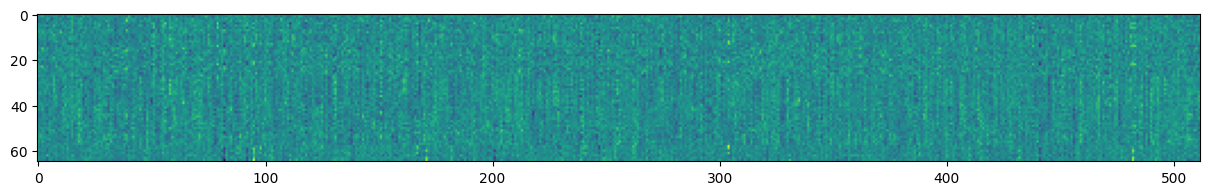

In [61]:
plt.figure(figsize=(15,15))
plt.imshow(doc_embeddings)

65
-0.21018207
(20, 65)
600


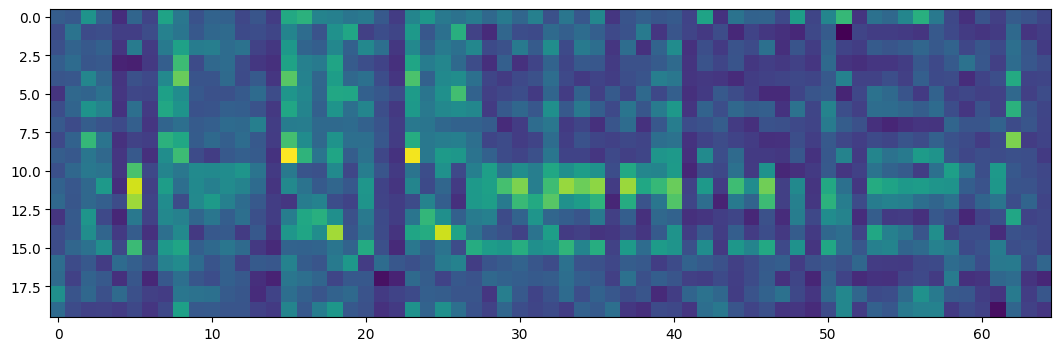

In [62]:
distance_matrix = pairwise_distances(centroids, doc_embeddings , metric='cosine', n_jobs=1)
distance_matrix = (distance_matrix * -1) + 1.0
 
plt.figure(figsize=(30,4))
plt.imshow( distance_matrix )
# plt.plot(np.array(distance_matrix.T[0]))
print(len(distance_matrix[0]))
 
print( distance_matrix.min())
print( distance_matrix.shape)
print( distance_matrix.argmax())

In [63]:
def relu(x: np.ndarray, relu_th: float = 0.0) -> np.ndarray:
  _relu = x * (x > relu_th)
  return _relu


distance_threshold 0.7117495

--------------------
--------------------
--------------------
--------------------
--------------------
--------------------
--------------------
--------------------
--------------------
--------------------
--------------------
--------------------
--------------------
--------------------
--------------------
--------------------
--------------------
--------------------
--------------------
--------------------
0.564191 9


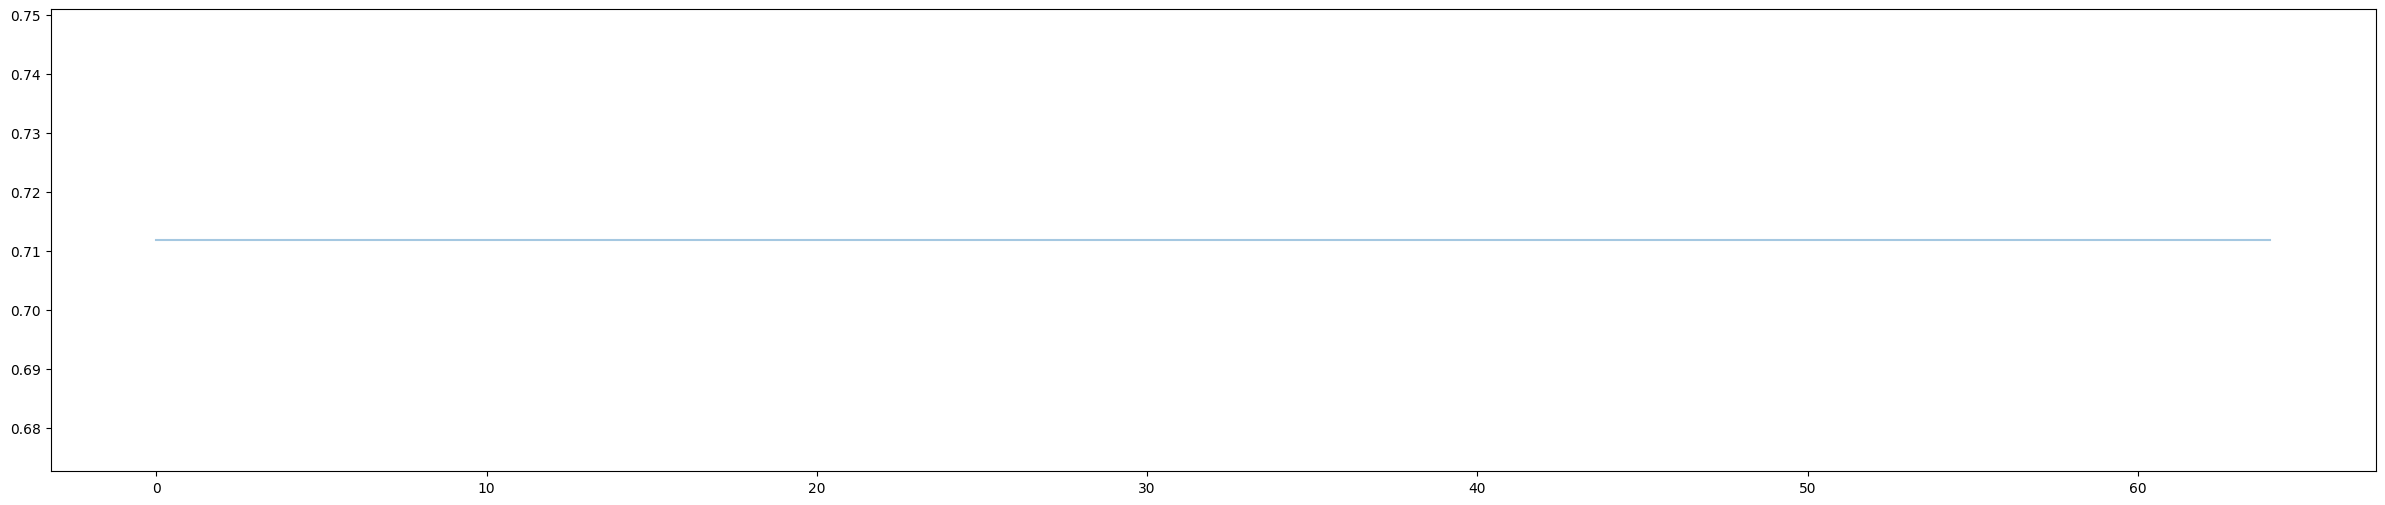

In [64]:
eps = 0.01
# del threshold # = 0.7 #0.9 *  distance_matrix.max()
print('distance_threshold', distance_threshold)
print()
sim_max = 0
# i_max = 0

plt.figure(figsize=(30,6))
plt.plot([distance_threshold]*len(sample_doc.sentence_map), alpha=0.4 )
i_max = 0
for k in range(n_clusters):    
    print('-'*20)
    av = distance_matrix[k] 
    
    ii = av.argmax()
    sim = av[ii]
    if (sim > distance_threshold):
        plt.plot(av)
        print( f"{k}=cluster \t {av[ii]}=similarity, \n {sample_doc.sentence_map.tokens[ii]} ")
        _span = sample_doc.sentence_map.remap_span((ii, ii + 1), sample_doc.tokens_map)
        print(_span)
    
    if sim > sim_max:
        i_max = k
        sim_max = sim
        
print(sim_max, i_max)

In [65]:
relu_threshold =  0.85 *  distance_matrix.max()
renderer_.render_color_text(sample_doc.sentence_map.tokens, relu(distance_matrix[i_max], relu_threshold), _range=(0,1), separator='<br>')

## Test no-insides DOC

In [66]:
%%time
from bson import ObjectId

# doc =

if SELF_TEST and False:
    sample_db_doc    =  get_doc_by_id(ObjectId('60dec1f556214d9842813fcb'))    
    sample_j_doc  = DbJsonDoc(sample_db_doc)
    sample_doc    = sample_j_doc.asLegalDoc()
    
    
    print(sample_doc)
    sample_doc.sentence_map = tokenize_doc_into_sentences_map(sample_doc.tokens_map.get_full_text(), mean_len)

#     print(sample_doc)

    doc_embeddings = embedd_strings(sample_doc.sentence_map.tokens)

CPU times: user 6 µs, sys: 1 µs, total: 7 µs
Wall time: 10 µs


In [67]:
if SELF_TEST and False:
    X = doc_embeddings
    distance_matrix = pairwise_distances(X, centroids, metric='cosine', n_jobs=1)
    # distance_matrix = relu ( ((distance_matrix * -1)+1) , _mx-0.01)

    distance_matrix = (distance_matrix * -1)+1.0
    distance_matrix = distance_matrix.T
    plt.figure(figsize=(30,4))
    plt.imshow( distance_matrix )
    # plt.plot(np.array(distance_matrix.T[0]))
    print(len(distance_matrix[0]))

In [68]:
if SELF_TEST and False:
    eps = 0.01
    threshold = 0.85 #0.9 *  distance_matrix.max()
    print('threshold', threshold)
    print()
    sim_max=0
    i_max=0
    plt.figure(figsize=(30,6))
    plt.plot([threshold]*len(sample_doc.sentence_map), alpha=0.4 )
    for k in range(n_clusters):    
        print('-'*20)
        v = distance_matrix[k] 
        av = v #relu(v, threshold) ## attention vector

        ii = av.argmax()
        sim = av[ii]
        if (sim > threshold):
            plt.plot(av)
            print( f"{k}=cluster \t {av[ii]}=similarity, \n {sample_doc.sentence_map.tokens[ii]} ")

        if sim>sim_max:
            i_max = k
            sim_max = sim
    print(sim_max, i_max)

In [69]:
if SELF_TEST and False:
    relu_threshold =  0.99 *  distance_matrix.max()
    renderer_.render_color_text(sample_doc.sentence_map.tokens, distance_matrix[i_max])

# End mlflow run

In [70]:
print(active_mlflow_run.info)

print('see results at')
print(f'{mlflow.get_registry_uri()}/#/experiments/{active_mlflow_run.info.experiment_id}/runs/{active_mlflow_run.info.run_id}')


mlflow.end_run()

<RunInfo: artifact_uri='mlflow-artifacts:/959696225534194922/53044ab0d85a4d9e928f5bd422d9ea74/artifacts', end_time=None, experiment_id='959696225534194922', lifecycle_stage='active', run_id='53044ab0d85a4d9e928f5bd422d9ea74', run_name='charming-bat-559', run_uuid='53044ab0d85a4d9e928f5bd422d9ea74', start_time=1680697005607, status='RUNNING', user_id='root'>
see results at
http://192.168.10.38:5000/#/experiments/959696225534194922/runs/53044ab0d85a4d9e928f5bd422d9ea74
